In [1]:
# Scientific libraries
import numpy_html
import numpy as np

# import Pandas

import pandas as pd

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike') 
jtplot.style(context='notebook', fscale=1, grid=False)

from mpltools import color as mpl_color


from glob import glob
import copy
import collections

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"

dark = yellow
mid= green
from bayescorner import bayescorner

import stan_utility
#import warnings
#warnings.simplefilter('ignore')

# Hierarchical Generalized Linear Models

While we have been fitting lines, it is important to note that a linear model is a special case of a generalized linear models (GLMs). We can write this as:

$$ y_{i}=\beta_{0}+\beta_{1} x_{1 i}+\ldots+\beta_{p} x_{p i}+\epsilon_{i} $$

These models are used in variety of applications. Fitting them can be difficult but is well studied. In particular, depending on their likelihood, the models can be used for high-dimensional prediction and classification. In many ways, these are the Bayesian/probabilistic version machine learning. 

However, we will stick with our simple linear model to discuss hierarchies. A hierarchical model is one where parameters can depend on each other via different levels of the model. 


$$ \pi\left(\phi, \theta_{j} | y\right) \propto \pi\left(y_{j} | \theta_{j}\right) \pi\left(\theta_{j} | \phi\right) \pi(\phi) $$

![alt text](bayesh.png "Title")

## Linear model with multiple intercepts

Now we will build generate some data from a model

In [2]:
np.random.seed(1234)

In [11]:
# create the number of obeservations 
# and groups

N = 4500
N_groups = 10

# randomly distributed x values
x1 = np.random.uniform(-1, 1, size=N)

# create an index for the groups
groups = np.array([int(N / N_groups) * [i] for i in range(N_groups)]).flatten()

# sample from the hyper distribtuion

mu_beta = 0.
sigma_beta = 3.0

beta0 = np.random.normal(loc=mu_beta, scale=sigma_beta, size=N_groups)

# set the slope
beta1 = 1

# compute the line
mu = beta1*x1 + beta0[groups]

# observation error
sigma = 2

# data
y = np.random.normal(loc=mu, scale=sigma, size=N)

In [12]:
cc = mpl_color.color_mapper([min(beta0),max(beta0)],'viridis')

<IPython.core.display.Javascript object>


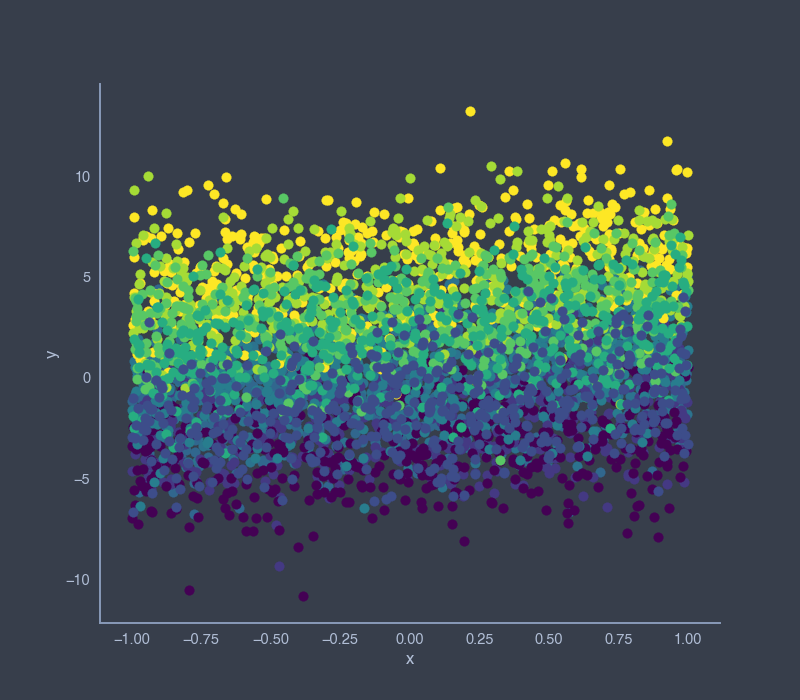

Text(0, 0.5, 'y')

In [14]:
fig, ax = plt.subplots()


for i in range(N_groups):
    
    idx = groups == i
    
    ax.scatter(x1[idx], y[idx],color=cc(beta0[i]))

    
    
    
ax.set_xlabel('x')
ax.set_ylabel('y')    

In [15]:
N_model = 100
x_model = np.linspace(-1, 1, N_model)

data = dict(
    N=N,
    N_groups=N_groups,
    groups=groups + 1,
    x1=x1,
    y=y,
    sigma=sigma,
    N_model=N_model,
    x_model=x_model,
)

In [16]:
cat hglm.stan

data {

  int N; // number of observations
  int N_groups; // number of groups
  int groups[N]; // group index

  vector[N] x1; // x data
  vector[N] y; // y data

  real<lower=0> sigma; // error

  int N_model; // for plotting

  vector[N_model] x_model; // for plotting
  
  

  

}

parameters {

  vector[N_groups] beta0; // group level intercept
  real beta1; // population level slope

  real mu_beta; // mean of group intercept distribtuion
  real<lower=0> sigma_beta; // spread in group level distribution
  
}


transformed parameters {
  vector[N] mu; // likelihood mean


  mu = beta0[groups] + beta1 * x1;
  
}


model {

  beta1 ~ normal(0, 5); 


  // hyper priors for intercept
  mu_beta ~ normal(0, 10);
  sigma_beta ~ cauchy(0, 2.5);

  // group level prior
  beta0 ~ normal(mu_beta, sigma_beta);

  // likelihood
  y ~ normal(mu,sigma);

}


generated quantities {

  vector[N_model] lines[N_groups];

  for (n in 1:N_groups) {


    lines[n] = beta0[n] + beta1 * x_model;
    

  }

In [17]:
model = stan_utility.compile_model("hglm.stan", model_name="hglm")
fit = model.sampling(data=data, iter=2000, seed=32423)

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<IPython.core.display.Javascript object>


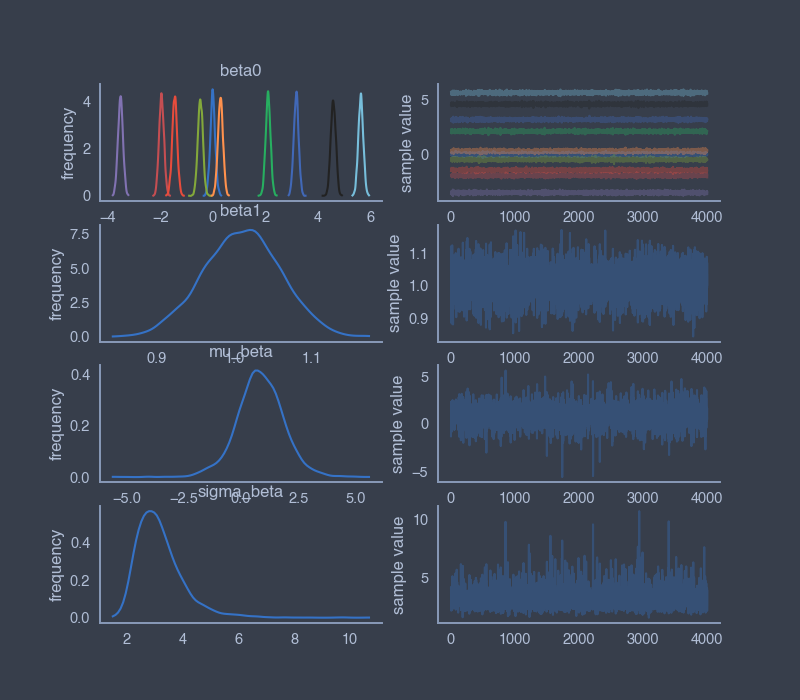

In [18]:
fit.plot(pars=["beta0", "beta1", "mu_beta", "sigma_beta"]);

<IPython.core.display.Javascript object>


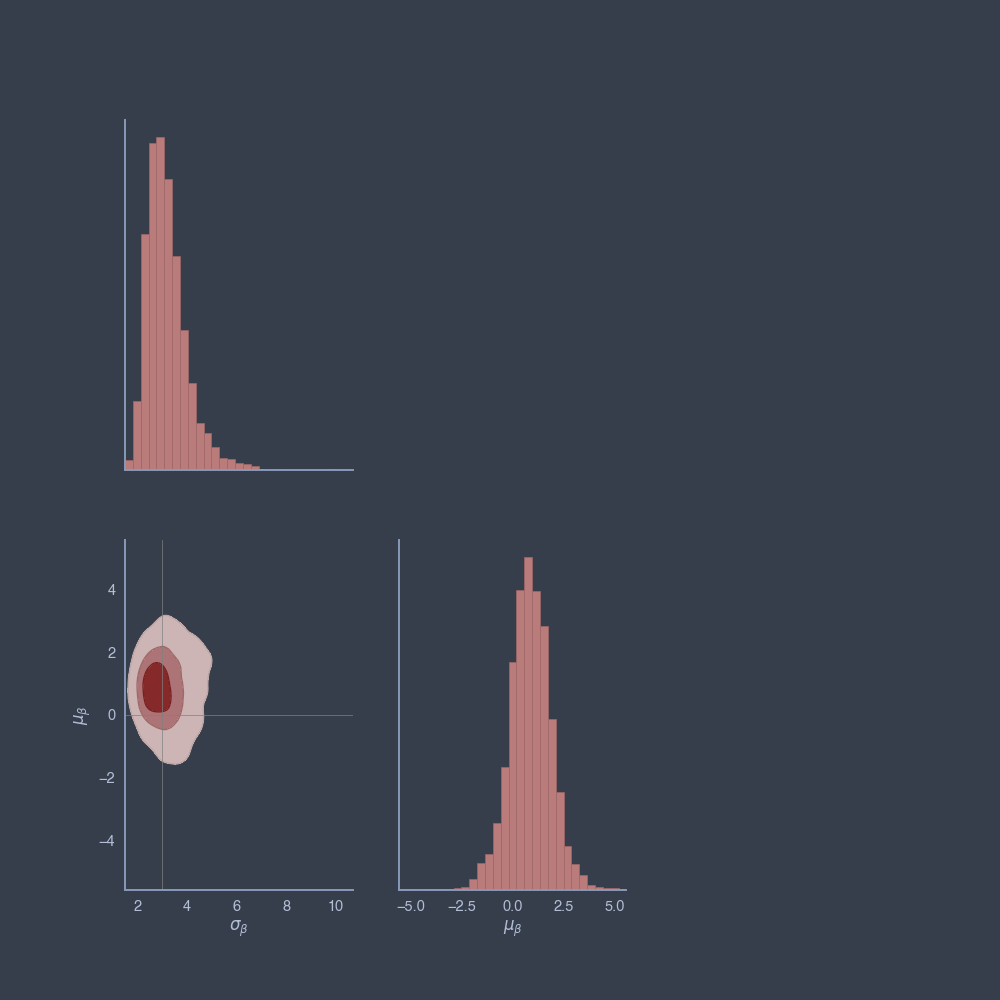

In [19]:
chain = fit.extract()

bayescorner(params=[chain['mu_beta'], chain['sigma_beta']],
            param_names=[r'$\mu_{\beta}$', r'$\sigma_{\beta}$'],
            truth=[mu_beta, sigma_beta  ]
);

<IPython.core.display.Javascript object>


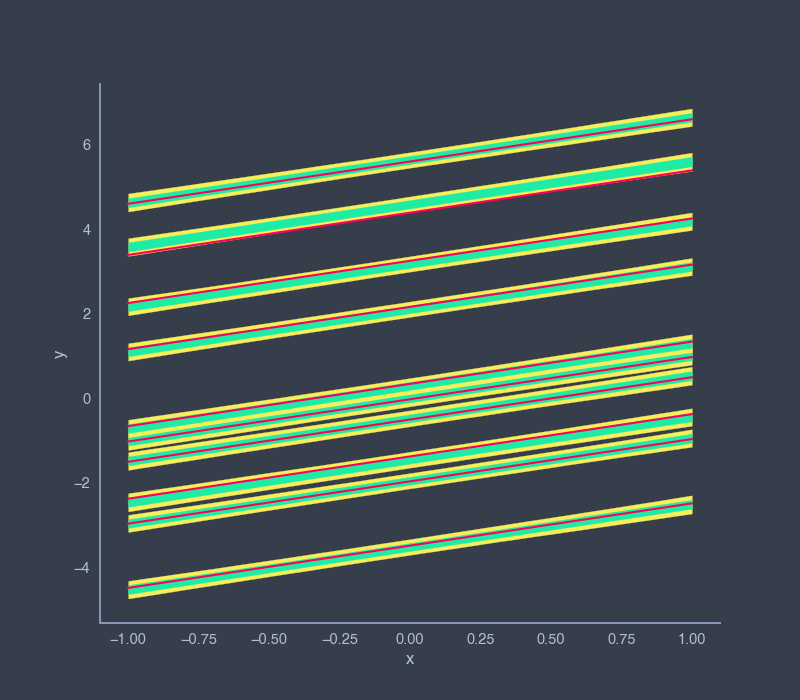

Text(0, 0.5, 'y')

In [21]:
fig, ax = plt.subplots()

chain = fit.extract()
for n in range(N_groups):
    level = 95

    ax.fill_between(x_model,
                    np.percentile(chain['lines'][:,n,:], 50 - 0.5*level, axis=0 ),
                    np.percentile(chain['lines'][:,n,:], 50 + 0.5*level, axis=0 ),
                    color=dark)

    level = 68

    ax.fill_between(x_model,
                    np.percentile(chain['lines'][:,n,:], 50 - 0.5*level, axis=0 ),
                    np.percentile(chain['lines'][:,n,:], 50 + 0.5*level, axis=0 ),
                    color=mid)
    
    ax.plot(x_model, beta0[n] + beta1 * x_model, color=red)

#ax.plot(x_model, m_true*x_model+b_true,color='limegreen',ls='--',zorder=10000)

#ax.scatter(x_obs, y_obs, c='k')

ax.set_xlabel('x')
ax.set_ylabel('y')

## Linear model with multiple intercepts and slopes

Now we also add in multiple slopes

In [25]:
N = 600
N_groups = 10
x1 = np.random.uniform(-1, 1, size=N)

groups = np.array([int(N / N_groups) * [i] for i in range(N_groups)]).flatten()


mu_beta0 = 0
sigma_beta0 = 4.0

mu_beta1 = 2
sigma_beta1 = 5.0


beta0 = np.random.normal(loc=mu_beta0, scale=sigma_beta0, size=N_groups)

beta1 = np.random.normal(loc=mu_beta1, scale=sigma_beta1, size=N_groups)

mu = beta1[groups] * x1 + beta0[groups]

sigma = 5

y = np.random.normal(loc=mu, scale=sigma, size=N)

<IPython.core.display.Javascript object>


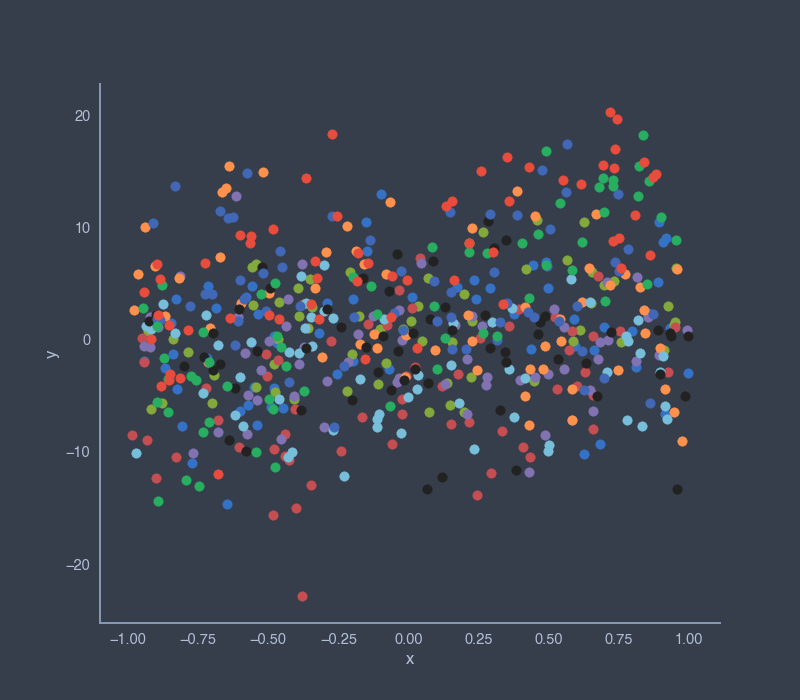

Text(0, 0.5, 'y')

In [26]:
fig, ax = plt.subplots()


for i in range(N_groups):

    idx = groups == i

    ax.scatter(x1[idx], y[idx])


ax.set_xlabel("x")
ax.set_ylabel("y")

If we didn't know that there were multiple groups, the data would look like it was coming from a single model

<IPython.core.display.Javascript object>


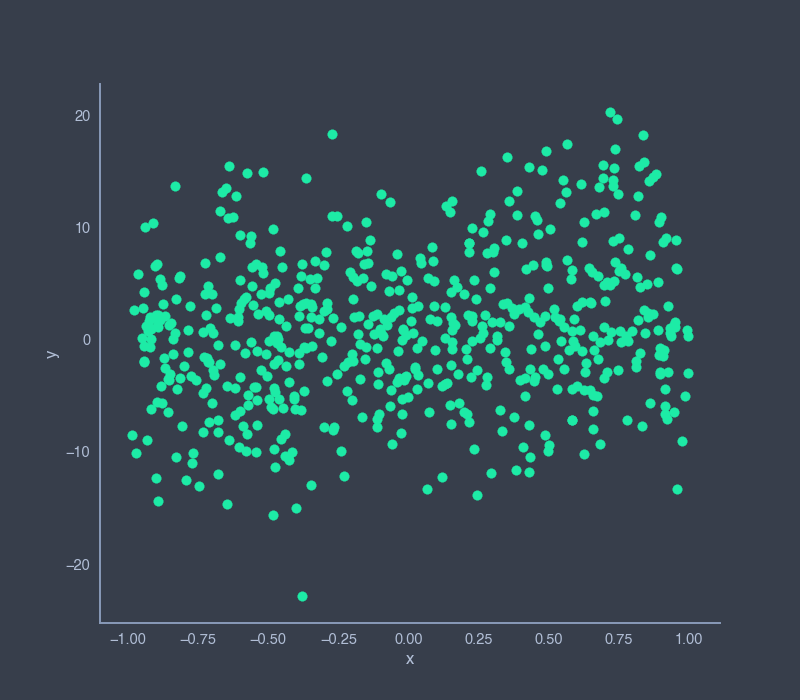

Text(0, 0.5, 'y')

In [27]:
fig, ax = plt.subplots()


for i in range(N_groups):

    idx = groups == i

    ax.scatter(x1[idx], y[idx], c=green)


ax.set_xlabel("x")
ax.set_ylabel("y")

In [28]:
N_model = 100
x_model = np.linspace(-1, 1, N_model)

data = dict(
    N=N,
    N_groups=N_groups,
    groups=groups + 1,
    x1=x1,
    y=y,
    sigma=sigma,
    N_model=N_model,
    x_model=x_model,
)

In [29]:
cat hglm2.stan

data {

  int N;
  int N_groups;
  int groups[N];

  vector[N] x1;
  vector[N] y;

  real<lower=0> sigma;

  int N_model;

  vector[N_model] x_model;
  
  

  

}

parameters {

  vector[N_groups] beta0;
  vector[N_groups] beta1;

  real mu_beta0;
  real<lower=0> sigma_beta0;

  real mu_beta1;
  real<lower=0> sigma_beta1;

  
}


transformed parameters {
  vector[N] mu;


  mu = beta0[groups] + beta1[groups] .* x1;
  
}


model {



  mu_beta0 ~ normal(0, 10);
  sigma_beta0 ~ cauchy(0, 2.5);

  beta0 ~ normal(mu_beta0, sigma_beta0);


  mu_beta1 ~ normal(0, 10);
  sigma_beta1 ~ cauchy(0, 2.5);

  beta1 ~ normal(mu_beta1, sigma_beta1);

 
  y ~ normal(mu,sigma);

}


generated quantities {

  vector[N_model] lines[N_groups];

  for (n in 1:N_groups) {



    lines[n] = beta0[n] + beta1[n] * x_model;
    

  }


  

}


In [30]:
model = stan_utility.compile_model("hglm2.stan", model_name="hglm2")
fit = model.sampling(data=data, iter=2000)

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<IPython.core.display.Javascript object>


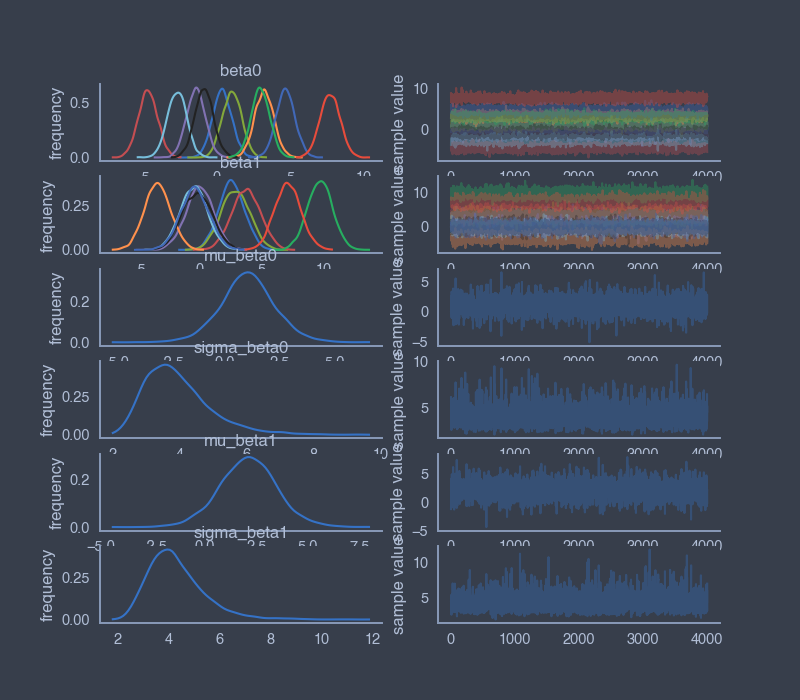

In [31]:
fit.plot(pars=['beta0', 'beta1' , 'mu_beta0', 'sigma_beta0', 'mu_beta1', 'sigma_beta1']);

<IPython.core.display.Javascript object>


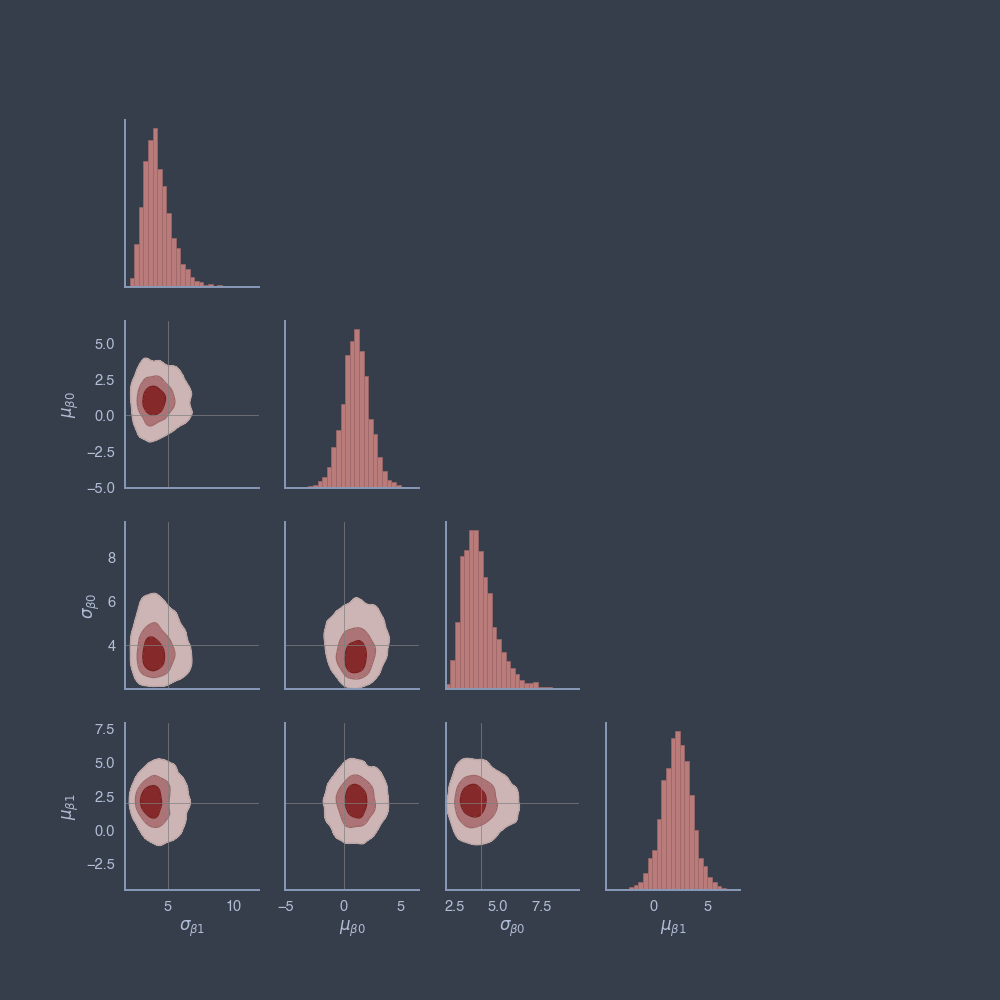

In [32]:
chain = fit.extract()

bayescorner(params=[chain['mu_beta0'], chain['sigma_beta0'], chain['mu_beta1'], chain['sigma_beta1']],
            param_names=[r'$\mu_{\beta0}$', r'$\sigma_{\beta0}$',r'$\mu_{\beta1}$', r'$\sigma_{\beta1}$'],
            truth=[mu_beta0, sigma_beta0, mu_beta1, sigma_beta1  ]
);

<IPython.core.display.Javascript object>


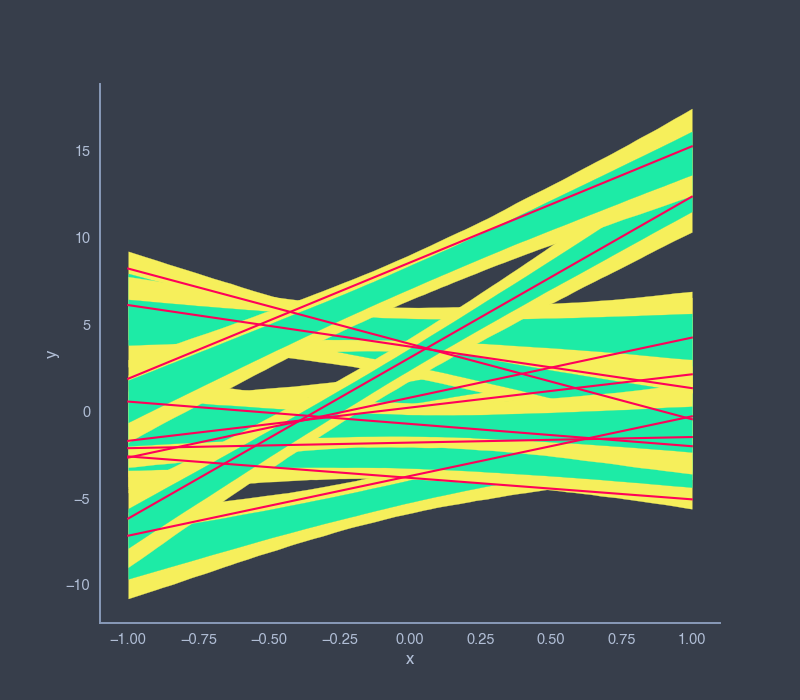

Text(0, 0.5, 'y')

In [34]:
fig, ax = plt.subplots()

chain = fit.extract()
for n in range(N_groups):
    level = 95

    ax.fill_between(x_model,
                    np.percentile(chain['lines'][:,n,:], 50 - 0.5*level, axis=0 ),
                    np.percentile(chain['lines'][:,n,:], 50 + 0.5*level, axis=0 ),
                    color=dark)

    level = 68

    ax.fill_between(x_model,
                    np.percentile(chain['lines'][:,n,:], 50 - 0.5*level, axis=0 ),
                    np.percentile(chain['lines'][:,n,:], 50 + 0.5*level, axis=0 ),
                    color=mid)
    
    ax.plot(x_model, beta0[n] + beta1[n] * x_model, color=red)

#ax.plot(x_model, m_true*x_model+b_true,color='limegreen',ls='--',zorder=10000)

#ax.scatter(x_obs, y_obs, c='k')

ax.set_xlabel('x')
ax.set_ylabel('y')